In [60]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
from pyspark.ml.feature import VectorAssembler
from torchvision import transforms, models
from pyspark.sql import SparkSession
from IPython.display import display
from PIL import Image
import pandas as pd
import numpy as np
import random
import torch
import os

Data Preparation

In [5]:
cars_train = pd.read_csv('Data/cars_train_data.csv')
cars_train.head()

,Unnamed: 0,x1,y1,x2,y2,Class,image
0,0,39,116,569,375,14,00001.jpg
1,1,36,116,868,587,3,00002.jpg
2,2,85,109,601,381,91,00003.jpg
3,3,621,393,1484,1096,134,00004.jpg
4,4,14,36,133,99,106,00005.jpg


In [30]:
cars_train.shape

(8144, 7)

In [32]:
cars_train.isnull().sum()

Unnamed: 0    0
x1            0
y1            0
x2            0
y2            0
Class         0
image         0
dtype: int64

In [34]:
cars_train.duplicated().sum()

0

In [31]:
cars_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  8144 non-null   int64 
 1   x1          8144 non-null   int64 
 2   y1          8144 non-null   int64 
 3   x2          8144 non-null   int64 
 4   y2          8144 non-null   int64 
 5   Class       8144 non-null   int64 
 6   image       8144 non-null   object
dtypes: int64(6), object(1)
memory usage: 445.5+ KB


In [35]:
cars_train.describe()

,Unnamed: 0,x1,y1,x2,y2,Class
count,8144.000000,8144.000000,8144.000000,8144.000000,8144.000000,8144.000000
mean,4071.500000,64.906803,108.661223,638.208620,416.431606,98.979371
std,2351.114629,82.198684,104.551635,410.776734,273.786000,56.503148
min,0.000000,1.000000,1.000000,76.000000,47.000000,1.000000
25%,2035.750000,19.000000,42.000000,392.000000,248.000000,50.000000
50%,4071.500000,39.000000,80.000000,569.000000,360.000000,99.000000
75%,6107.250000,79.000000,138.250000,746.250000,477.000000,148.000000
max,8143.000000,1648.000000,1508.000000,5205.000000,3389.000000,196.000000


Q1- Perform this transformation using the Torchvision package in PyTorch.

In [21]:
directory = 'Data/cars_train'

In [22]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(    
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

image_paths = [os.path.join(directory, img) for img in os.listdir(directory) if img.endswith(('.jpg'))]

transformed_images = []
for image_path in image_paths:
    image = Image.open(image_path).convert("RGB")  
    transformed_image = transform(image)
    transformed_images.append(transformed_image)

transformed_images = torch.stack(transformed_images)

print(transformed_images.shape)

torch.Size([100, 3, 224, 224])


Q2- Create class C.

In [23]:
class C:
    def __init__(self):
        # load pre-trained ResNet-18 model
        self.model = models.resnet18(pretrained=True)

        self.numberFeatures = 512
        
        # remove the final classification layer
        self.model = torch.nn.Sequential(*list(self.model.children())[:-1])
        
        # set the model to evaluation mode
        self.model.eval()
        
        # define the image transformations
        self.transform = transform

    def get_embedding(self, image_path):
        image = Image.open(image_path).convert("RGB")
        
        image = self.transform(image).unsqueeze(0)
        
        with torch.no_grad():
            embedding = self.model(image)
        
        # embedding to a 1D vector
        embedding = embedding.view(-1)
        
        # embedding to numpy array
        return embedding.numpy() 

Q3- Using class C, calculate the image embeddings for all images.

In [28]:
embedding_extractor = C()

embeddings = []
for image_path in image_paths:
    embedding = embedding_extractor.get_embedding(image_path)
    embeddings.append(embedding)


embeddings = np.array(embeddings)

embeddings.shape

/home/mina/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mina/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(100, 512)

Q4- Store the image embeddings in a CSV file.

In [29]:
df = pd.DataFrame(embeddings)

df.insert(0, "image_filename", [os.path.basename(path) for path in image_paths])

output_csv_path = "image_embeddings.csv"
df.to_csv(output_csv_path, index=False)

Q5- Create a Spark DataFrame that contains the image embeddings.

In [39]:
spark = SparkSession.builder.appName("lab5").getOrCreate()

In [ ]:
input_df = spark.read.option("header", "true").option('inferSchema', True).csv('image_embeddings.csv')

In [41]:
input_df.show()

25/02/26 11:22:06 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------+----------+----------+----------+-----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+---------+-----------+-----------+-----------+-----------+----------+---------+----------+-----------+-----------+------------+----------+----------+-----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+-----------+----------+----------+-----------+-----------+-----------+----------+------------+----------+-----------+----------+-----------+----------+------------+-----------+----------+----------+-----------+----------+-----------+----------+-----------+----------+------------+----------+----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+----------+----------+-----------+-----------+----------+------------+-----------+------

Q6- The PySpark LSH implementation requires a vector column as input. Perform a transformation to represent the relevant columns as a single vector.

In [46]:
vector_columns = input_df.columns[1:]
assembler = VectorAssembler(inputCols=vector_columns, outputCol="features")
output = assembler.transform(input_df)
output.show()

+--------------+----------+----------+----------+-----------+----------+----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+----------+-----------+-----------+-----------+-----------+-----------+-----------+------------+---------+-----------+-----------+-----------+-----------+----------+---------+----------+-----------+-----------+------------+----------+----------+-----------+----------+-----------+----------+----------+-----------+----------+----------+-----------+----------+-----------+----------+----------+-----------+-----------+-----------+----------+------------+----------+-----------+----------+-----------+----------+------------+-----------+----------+----------+-----------+----------+-----------+----------+-----------+----------+------------+----------+----------+-----------+-----------+-----------+------------+-----------+-----------+-----------+----------+----------+-----------+-----------+----------+------------+-----------+------

In [50]:
output.printSchema()

root
 |-- image_filename: string (nullable = true)
 |-- features: vector (nullable = true)



In [49]:
output = output.select('image_filename', 'features')
output.show()

+--------------+--------------------+
|image_filename|            features|
+--------------+--------------------+
|     00001.jpg|[0.6907758,3.6337...|
|     00002.jpg|[0.79590076,2.974...|
|     00003.jpg|[1.1031526,1.7856...|
|     00004.jpg|[0.92942965,2.489...|
|     00005.jpg|[0.80739474,1.101...|
|     00006.jpg|[0.6282114,1.4742...|
|     00007.jpg|[0.88186884,3.302...|
|     00008.jpg|[0.75993174,2.940...|
|     00009.jpg|[1.3224553,2.2210...|
|     00010.jpg|[1.3231993,0.9070...|
|     00011.jpg|[0.14561786,2.038...|
|     00012.jpg|[0.8248321,1.0697...|
|     00013.jpg|[0.9695163,3.3251...|
|     00014.jpg|[0.8161615,0.9884...|
|     00015.jpg|[0.9740456,2.2400...|
|     00016.jpg|[1.6987169,0.5625...|
|     00017.jpg|[0.63210756,3.281...|
|     00018.jpg|[0.6579562,3.5945...|
|     00019.jpg|[1.2575921,2.4562...|
|     00020.jpg|[1.0503852,3.6998...|
+--------------+--------------------+
only showing top 20 rows



Q7- Create a model using the BucketedRandomProjection.

In [52]:
bucketed_random_projection = BucketedRandomProjectionLSH(
    inputCol="features", 
    outputCol="hashes",
    numHashTables=10, 
    bucketLength=2.0
)
model = bucketed_random_projection.fit(output)

25/02/26 11:33:30 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


Q8- Transform the DataFrame using the newly created LSH model. The resulting DataFrame will include a hash column containing a hashed representation of the image embeddings.

In [53]:
df_hashed = model.transform(output)
df_hashed.select("image_filename", "features", "hashes").show(5, truncate=False)

+--------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Q9- Select a random image.

In [55]:
directory

'Data/cars_train'

00087.jpg


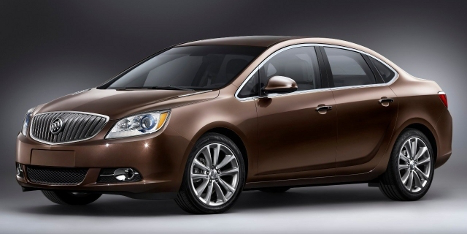

In [65]:
test_image = random.choice(df_hashed.select("image_filename").collect())['image_filename']
print(test_image)
display(Image.open(directory + '/' + test_image))

Q10- Convert this image into a vector format.

In [66]:
query_row = df_hashed.filter(df_hashed["image_filename"] == test_image).select("features").collect()[0]
query_vector = query_row["features"]

print(f"Query image vector: {query_vector}")

Query image vector: [1.4325749,1.3698907,1.2163358,0.018161265,0.8174074,0.67269826,0.69971967,0.055091415,2.377729,1.1852031,0.13550062,0.42711616,0.0048346957,2.1852415,0.680339,0.6751538,0.5045647,0.7838066,0.175837,0.36270422,0.2734297,1.8213665,0.077765405,0.08239548,1.1097703,2.247669,1.2790827,2.944626,0.36268386,0.1269084,0.01930756,0.18228914,1.32164,0.44889992,0.08239882,0.16271073,0.16925314,0.9634263,0.29874536,0.36481223,0.89792764,2.0195577,0.5009188,1.3860682,0.5574719,1.6250052,1.3296244,0.21939772,0.15202175,0.17960821,0.15675856,0.16317153,0.087751396,0.17582734,1.0739994,0.33759362,0.49910417,0.17991562,0.059809364,0.38676834,0.025550868,0.82033545,1.7899461,0.5026828,0.5042109,0.097446226,0.63073736,0.46994555,0.07570663,0.9818735,0.22766522,0.041865297,0.5559368,0.30431622,0.84727293,0.51757693,0.29095685,0.36408475,0.4831581,0.4775425,0.15595134,0.08826421,0.58970237,1.6116596,0.45914057,0.86815697,0.50492334,0.865292,1.1511666,1.7737718,0.32780185,0.46079168,1.26

Q11- Perform an approximate search for the five nearest neighbors.

In [74]:
neighbors = 5
nearest_neighbors = model.approxNearestNeighbors(df_hashed, query_vector, neighbors)

nearest_neighbors.select("image_filename", "hashes").show(truncate=False)

+--------------+------------------------------------------------------------------------------+
|image_filename|hashes                                                                        |
+--------------+------------------------------------------------------------------------------+
|00087.jpg     |[[0.0], [-1.0], [-2.0], [-1.0], [-1.0], [0.0], [-1.0], [-1.0], [-2.0], [0.0]] |
|00009.jpg     |[[0.0], [-1.0], [-2.0], [-1.0], [-1.0], [0.0], [-2.0], [-1.0], [-2.0], [-1.0]]|
|00026.jpg     |[[0.0], [-1.0], [-2.0], [-1.0], [-1.0], [0.0], [-1.0], [0.0], [-2.0], [-1.0]] |
|00077.jpg     |[[0.0], [-1.0], [-2.0], [-1.0], [-1.0], [0.0], [-1.0], [0.0], [-1.0], [-1.0]] |
|00023.jpg     |[[0.0], [-1.0], [-2.0], [-1.0], [-1.0], [0.0], [-1.0], [0.0], [-1.0], [0.0]]  |
+--------------+------------------------------------------------------------------------------+



Q12- Display the images that correspond to the five neighbors.

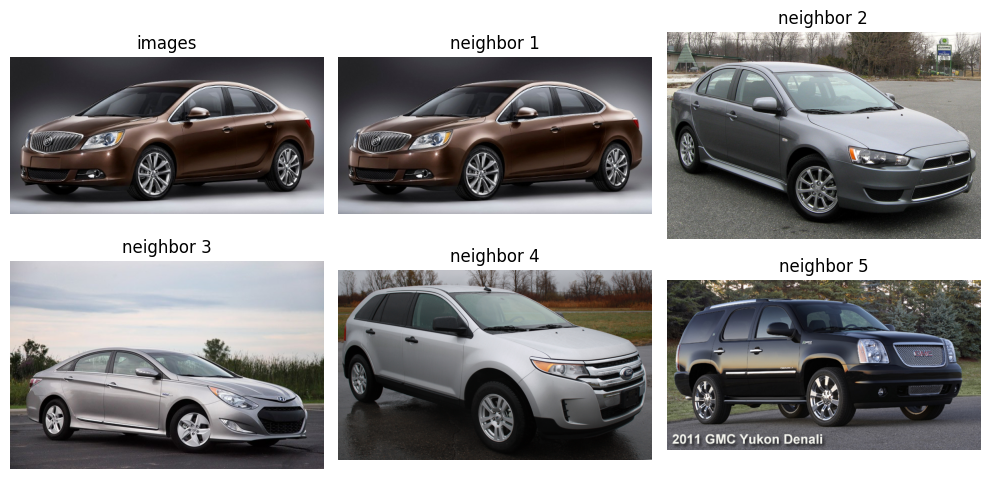

In [73]:
import matplotlib.pyplot as plt
from PIL import Image

def display_images(image_name, neighbor_names, directory):

    query_image_path = os.path.join(directory, image_name)
    query_image = Image.open(query_image_path)
    
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 3, 1)
    plt.imshow(query_image)
    plt.title("images")
    plt.axis("off")
    
    for i, neighbor_names in enumerate(neighbor_names, start=2):
        neighbor_image_path = os.path.join(directory, neighbor_names)
        neighbor_image = Image.open(neighbor_image_path)
        
        plt.subplot(2, 3, i)
        plt.imshow(neighbor_image)
        plt.title(f"neighbor {i-1}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

neighbor_names = [row["image_filename"] for row in nearest_neighbors.collect()]

display_images(test_image, neighbor_names, directory)